#  <center> Image Segmentation <center>

In [ ]:
import os 
from glob import glob
import PIL
from PIL import Image
from skimage import io, color
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget -O part2data.zip https://github.com/wwang2/ML4MolEng/blob/master/psets/ps5/part2_data.zip?raw=true
! rm -r segmentation_data
! mkdir segmentation_data/
! unzip part2data.zip -d segmentation_data

Streaming output truncated to the last 5000 lines.
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/8764f0cef29977b4d47fb037851a71af14987901a6aa6737bec57dc050750fd7.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/c6a7a0c3c89a1e2ca5c068a61e6e9f84390233dbc587792503f348296ac6b78f.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/3382020ee0ed65d8d303751947fd261e3c64d823b27d756a9871b5dde2129462.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/9fd1c120f489218285c8fae05dc8ee20e5518443d8428bbca0c50343d4695a15.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/97027951540138eb9e8b8abaa7ea1633419ef1bfe75418e7fb97e6a83d272e19.png  
  inflating: s

In [ ]:
# get all image file paths
paths = glob("segmentation_data/part2_segdata/*")

In [ ]:

def parse_data(path):

    # define data folders
    x_path = os.path.join(path, "images/")
    y_path = os.path.join(path, "masks/")

    # get all data paths 
    x_file = glob(os.path.join(x_path, "*.png"))[0]
    y_files = glob(os.path.join(y_path, "*.png"))

    # parse in data
    x = np.array(Image.open(x_file))
    
    # collect masks
    masks = np.array([np.array(Image.open(y)) for y in y_files])
    y = np.zeros_like(masks[0])
    for y_raw in masks:
        y = np.maximum(y, y_raw)

    # normalize
    x = x / 255.0
    y = y / 255.0

    return x, y[..., None]

(256, 256, 4) (256, 256, 1)


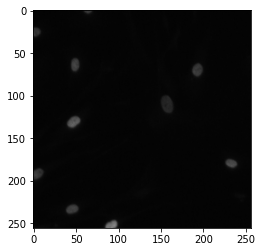

In [ ]:
# load one image 
x, y = parse_data(paths[0])
print(x.shape, y.shape)

plt.imshow(x)
plt.show()

### 2.1 Build data-sets and data-loaders

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split dataset to train/val/test ( Ratios: 0.8*0.875=0.7 / 0.8*0.125=0.1 / 0.2 )
images_train_val, images_test = train_test_split(paths, test_size=0.2)
images_train, images_val = train_test_split(images_train_val, test_size=0.125)


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import random

# dictionary labels 

class ImageDataset(Dataset):
    def __init__(self, image_paths):
        
        '''
        Image dataset object that load images and transform images
        
        '''
        
        self.paths = image_paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        # read images and mask from file path 
        img, mask = parse_data(path)

        angle = random.randint(-60, 60)

        transform = T.Compose([T.ToTensor()])

        # transform images
        img = transform(img)
        mask = transform(mask)

        img = TF.rotate(img, angle)
        mask = TF.rotate(mask, angle)

        return img, mask

In [ ]:

X_train = ImageDataset(images_train)
X_val = ImageDataset(images_val)
X_test = ImageDataset(images_test)


In [ ]:
from torch.utils.data import DataLoader

# Build dataloader
batchsize = 4
train_loader = DataLoader(dataset=X_train, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset=X_val, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(dataset=X_test, batch_size=batchsize, shuffle=True)

### 2.2 Train a U-net model that performs image segmentation

In [ ]:
from torch import nn 

class DownSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(DownSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        conv_out = self.conv(x)
        output = self.max_pool(conv_out)

        return output, conv_out


class UpSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(UpSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.conv_t = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, \
                                         padding=1, stride=2, output_padding=1)


    def forward(self, x, skip):

        conv_out = self.conv(x)
        output = self.conv_t(conv_out)

        output += skip

        return output


class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, padding=1, stride=1, name=None):
        super(ConvBlock, self).__init__()

        block = []
        # first conv layer
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # second conv layer
        block.append(nn.Conv2d(out_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # make sequential
        self.conv_block = nn.Sequential(*block)


    def forward(self, x):

        output = self.conv_block(x)

        return output
    
    
class UNet(nn.Module):

    def __init__(self, num_kernel=8, kernel_size=3, dim=4, target_dim=1):
        """UNet

        Inputs:
            num_kernel: int
                number of kernels to use for the first layer
            kernel_size: int
                size of the kernel for the first layer
            dims: int
                number of color channels for input images 
            target_dim: int 
                number of channels for the output mask
        """

        super(UNet, self).__init__()

        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = 1

        # encode
        self.encode_1 = DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):

        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)

        pred = self.activate(x)

        return pred


    def args_dict(self):
        """model arguments to be saved
        """

        model_args = {'dim': self.dim,
                      'target_dim': self.target_dim,
                      'num_kernel' : self.num_kernel,
                      'kernel_size' : self.kernel_size}

        return model_args


implement DICE loss function 

In [ ]:
def dice_loss(pred, target):                          
  
    loss = 1 - (2*torch.sum(pred * target) + 1) / (torch.sum(pred) + torch.sum(target) + 1)
    
    return loss

In [ ]:
def plot_seg(image, pred_seg, true_seg, mask_cutoff=0.1):

    """ Visualize segmentation results
        Inputs:
            image: orginal image, shape: 256 x 256 x 4
            pred_seg: predicted mask, shape: 256 x 256 x 1 or 256 x 256 
            true_seg: true mask, shape: 256 x 256 x 1 or 256 x 256
            mask_cutoff: if the maks values is larger than mask_cutoff, the mask will appear on the image
        """
    
    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
    fig.set_size_inches((15,15))
    
    pred_seg = pred_seg.squeeze()
    true_seg = pred_seg.squeeze()

    ax[0].set_title("original image")
    ax[1].set_title("prediction")
    ax[2].set_title("ground truth")

    pred_mask = np.zeros((256, 256))
    pred_mask[pred_seg > mask_cutoff] = 1
    y_mask = np.zeros((256, 256))
    y_mask[true_seg > mask_cutoff] = 1

    io.imshow(image, ax=ax[0])
    io.imshow(color.label2rgb(pred_mask,image,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None), ax=ax[1])
    io.imshow(color.label2rgb(y_mask,image,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None), ax=ax[2])

    plt.show()

finally train model

In [ ]:
from torch import nn

def train(model, dataloader, optimizer, device):
    
    '''
    A function train on the entire dataset for one epoch .
    
    Args: 
        model (torch.nn.Module()): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): Dataloader object for the train data
        optimizer (torch.optim.Optimizer(()): optimizer object to interface gradient calculation and optimization 
        device (str): Your string
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    batch_loss = 0
    model.train() # Set model to training mode 
    
    size = len(dataloader)

    for batch in dataloader:
        img, mask = batch
        img = img.float().to(device)
        mask = mask.float().to(device)
        #img.requires_grad=True
        # Compute prediction error
        pred = model(img)

        single_batch_loss = dice_loss(pred, mask)

        batch_loss += single_batch_loss

        # Backpropagation
        optimizer.zero_grad()
        single_batch_loss.backward()
        optimizer.step()
        
    batch_loss /= size

    return batch_loss


def validate(model, dataloader, device):
    
    '''
    A function validate on the validation dataset for one epoch .
    
    Args: 
        model (torch.nn.Module()): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): Dataloader object for the train data
        device (str): Your string
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    size = len(dataloader)
    val_loss = 0
    model.eval() # Set model to evaluation mode

    with torch.no_grad():    
        for batch in dataloader:
            img, mask = batch
            img = img.float().to(device)
            mask = mask.float().to(device)
            pred = model(img)

            val_loss += dice_loss(pred, mask)
    
    val_loss /= size
    
    return val_loss


In [ ]:
from torch.optim import Adam

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = UNet().to(device)

optimizer = Adam(model.parameters(), lr=0.001)


In [ ]:
print("epoch", "train loss", "validation loss", "test loss")

val_loss_curve = []
train_loss_curve = []
test_loss_curve = []

for epoch in range(20):
    
    # Compute train your model on training data
    epoch_loss = train(model, train_loader, optimizer, device)
    
    # Validate your on validation data
    val_loss = validate(model, val_loader, device)

    # Test your on testing data
    test_loss = validate(model, test_loader, device)
    
    # Record train, validation and test loss performance
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    test_loss_curve.append(test_loss)
    
    print(epoch, epoch_loss, val_loss, test_loss)

epoch train loss validation loss test loss
0 tensor(0.7702, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.7601, device='cuda:0') tensor(0.7154, device='cuda:0')
1 tensor(0.5707, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6815, device='cuda:0') tensor(0.6556, device='cuda:0')
2 tensor(0.3422, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2386, device='cuda:0') tensor(0.2273, device='cuda:0')
3 tensor(0.2155, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2054, device='cuda:0') tensor(0.2766, device='cuda:0')
4 tensor(0.1730, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1283, device='cuda:0') tensor(0.1533, device='cuda:0')
5 tensor(0.1503, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1149, device='cuda:0') tensor(0.1461, device='cuda:0')
6 tensor(0.1473, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0995, device='cuda:0') tensor(0.1488, device='cuda:0')
7 tensor(0.1335, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1173, device='cuda:0') tensor(0.1606

Show segmentation results for some images from test dataset

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


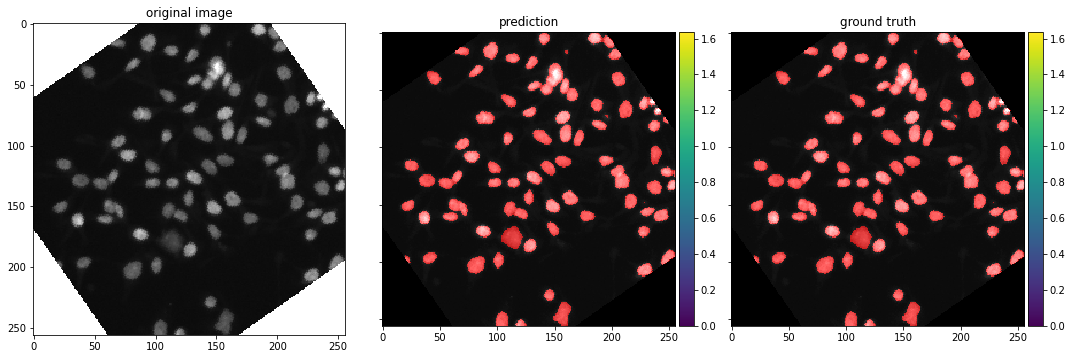

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


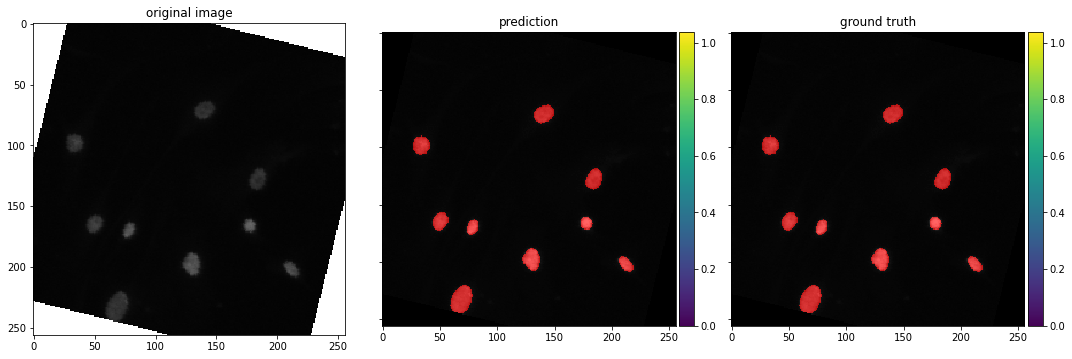

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


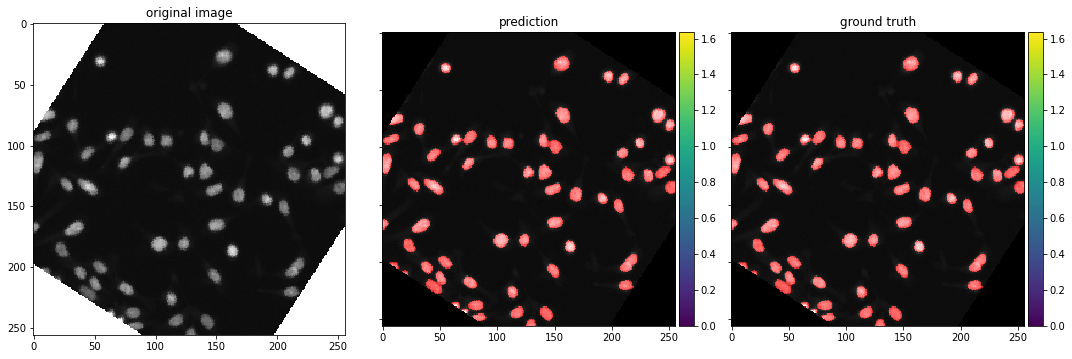

In [ ]:
def test_plot_seg(model, dataloader, device):

    model.eval() # Set model to evaluation mode

    test_loader_iter = iter(dataloader)

    with torch.no_grad():    
      img, mask = next(test_loader_iter)
      img = img.float().to(device)
      mask = mask.float().to(device)
      # validate your model on each batch here
      pred = model(img)

      img = img.detach().cpu().numpy()
      mask = mask.detach().cpu().numpy()
      pred = pred.detach().cpu().numpy()

      for i in range(3):
        img_plot = np.transpose(img[i],(2,1,0))
        mask_plot = np.transpose(mask[i],(2,1,0))
        pred_plot = np.transpose(pred[i],(2,1,0))

        plot_seg(img_plot, pred_plot, mask_plot, mask_cutoff=0.1)

test_plot_seg(model, test_loader, device)